# Text Classification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

from datasets import list_datasets, load_dataset
from huggingface_hub import notebook_login
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
from sklearn.preprocessing import MinMaxScaler
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertTokenizer,
    pipeline,
    TFAutoModel,
    TFAutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.nn.functional import cross_entropy, one_hot
from umap import UMAP

## The Dataset

### A First Look at Hugging Face Datasets

In [2]:
all_datasets = list_datasets()

C:\Users\stevi\AppData\Local\Temp\ipykernel_11348\374882858.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


In [3]:
print(f"There are {len(all_datasets)} datasets currently available on the Hub")

There are 116916 datasets currently available on the Hub


In [4]:
print(f"The first 10 are: {all_datasets[:10]}")

The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
emotions = load_dataset("emotion")

c:\venvs\venv_nlp_with_transformers\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions["train"]

In [8]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
len(train_ds)

16000

In [10]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [11]:
train_ds.column_names

['text', 'label']

In [12]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [13]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [14]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [15]:
emotions_local = load_dataset("json", data_files="./dair-ai/emotion/data/train.jsonl")

In [16]:
emotions_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

### From Datasets to DataFrames

In [17]:
emotions.set_format(type="pandas")

In [18]:
df = emotions["train"][:]

In [19]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [21]:
df["label_name"] = df["label"].apply(label_int2str)

In [22]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Classe Distribution

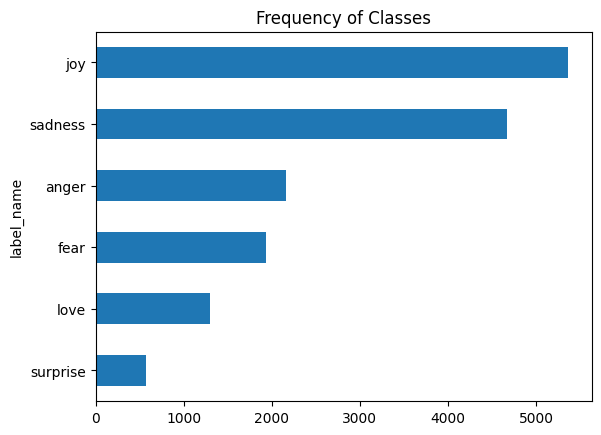

In [23]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### How Long Are Our Tweets?

In [24]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

In [25]:
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


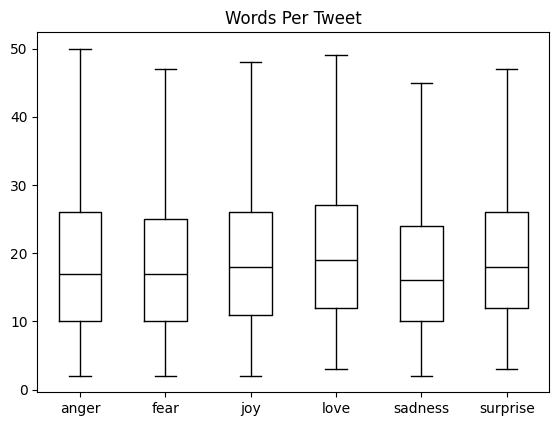

In [26]:
df.boxplot(
    "Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black"
)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [27]:
emotions.reset_format()

### From Text to Tokens

#### Character Tokenization

In [28]:
text = "Tokenizing text is a core task of NLP."

In [29]:
tokenized_text = list(text)

In [30]:
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [31]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

In [32]:
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [33]:
input_ids = [token2idx[token] for token in tokenized_text]

In [34]:
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [35]:
input_ids = torch.tensor(input_ids)

In [36]:
input_ids

tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])

In [37]:
one_hot_encodings = one_hot(input_ids, num_classes=len(token2idx))

In [38]:
one_hot_encodings.shape

torch.Size([38, 20])

In [39]:
one_hot_encodings

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0,

In [40]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [41]:
tokenized_text = text.split()

In [42]:
tokenized_text

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']

#### Subword Tokenization

In [43]:
model_ckpt = "distilbert-base-uncased"

In [44]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [45]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [46]:
encodeded_text = tokenizer(text)

In [47]:
encodeded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [48]:
tokens = tokenizer.convert_ids_to_tokens(encodeded_text.input_ids)

In [49]:
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [50]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [51]:
tokenizer.vocab_size

30522

In [52]:
tokenizer.model_max_length

512

In [53]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#### Tokenizing the Whole Dataset

In [54]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [55]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [56]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [57]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

### Training a Text Classifier

#### Transformers as Feature Exractors

**Using pretrained models**

In [58]:
model_ckpt = "distilbert-base-uncased"

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
device

device(type='cuda')

In [61]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

**Interoperability Between Frameworks**

In [62]:
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [63]:
# tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=False)  # weights in PyTorch
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


**Extracting the last hidden states**

In [64]:
text = "this is a test"

In [65]:
inputs = tokenizer(text, return_tensors="pt")

In [66]:
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [67]:
inputs = {k: v.to(device) for k, v in inputs.items()}

In [68]:
with torch.no_grad():
    outputs = model(**inputs)

In [69]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [70]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [71]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [72]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [73]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [74]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

**Creating a feature matrix**

In [75]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

In [76]:
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

**Visualizing the training set**

In [77]:
# Scale features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

In [78]:
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

In [79]:
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])


In [80]:
df_emb["label"] = y_train

In [81]:
df_emb.head()

,X,Y,label
0,4.128881,6.346864,0
1,-3.095347,5.866401,0
2,5.162989,2.973129,3
3,-2.603439,3.833174,2
4,-3.404876,4.077534,3


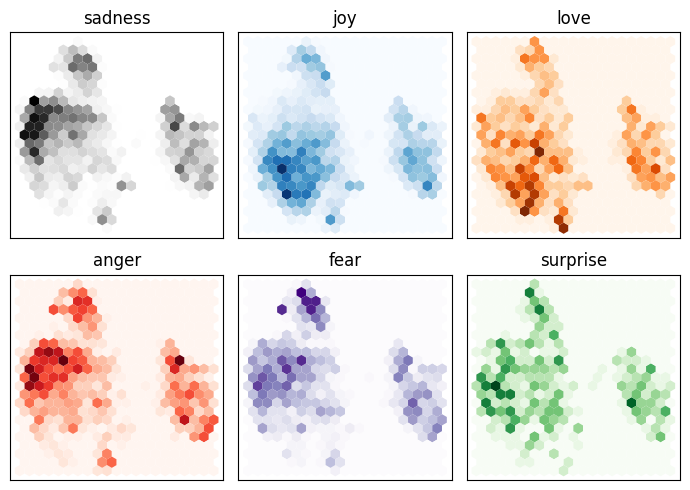

In [82]:
fg, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

**Training a simple classifier**

In [83]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)

In [84]:
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [85]:
lr_clf.score(X_valid, y_valid)

0.6355

In [86]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [87]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [88]:
dummy_clf.score(X_valid, y_valid)

0.352

In [89]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")

    fix, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

    plt.title("Normalized confusion matrix")
    plt.show()

In [90]:
y_preds = lr_clf.predict(X_valid)

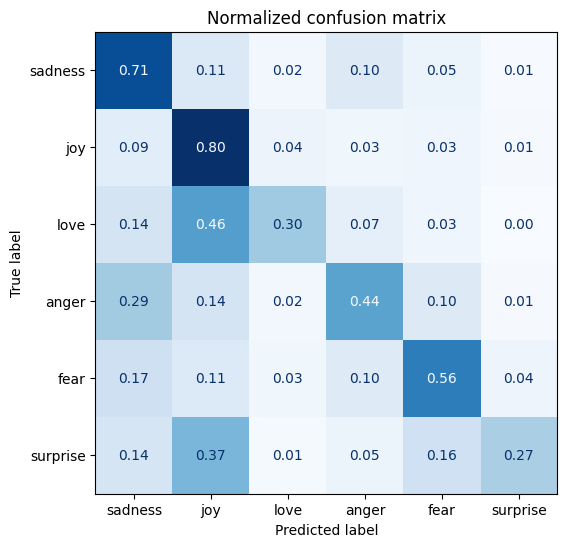

In [91]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### Fine-Tuning Transformers

**Loading a pretrained model**

In [92]:
num_labels = len(emotions["train"].features["label"].names)

In [93]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Defining the performance metrics**

In [94]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

**Training the model**

In [101]:
notebook_login()

In [104]:
batch_size = 64

In [105]:
logging_steps = len(emotions_encoded["train"]) // batch_size

In [109]:
# model_name = f"{model_ckpt}-finetuned-emotion"
model_name = f"{model_ckpt}"

In [110]:
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
)

In [111]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

In [112]:
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

TrainOutput(global_step=500, training_loss=0.5238163909912109, metrics={'train_runtime': 495.0078, 'train_samples_per_second': 64.645, 'train_steps_per_second': 1.01, 'train_loss': 0.5238163909912109, 'epoch': 2.0})

In [115]:
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [116]:
preds_output.metrics

{'test_loss': 0.2225184589624405,
 'test_accuracy': 0.9225,
 'test_f1': 0.9223847960269735,
 'test_runtime': 10.9098,
 'test_samples_per_second': 183.321,
 'test_steps_per_second': 2.933}

In [117]:
y_preds = np.argmax(preds_output.predictions, axis=1)

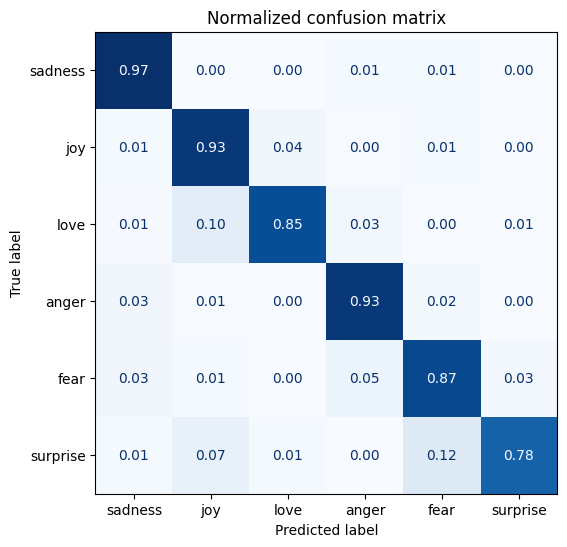

In [119]:
plot_confusion_matrix(y_preds, y_valid, labels)

**Fine-Tunning with Keras**

In [122]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels)

In [123]:
# The column names to convert to Tensorflow tensors
tokenizer_columns = tokenizer.model_input_names

In [127]:
tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"],
    shuffle=True,
    batch_size=batch_size,
)

c:\venvs\venv_nlp_with_transformers\Lib\site-packages\datasets\arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [128]:
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"],
    shuffle=False,
    batch_size=batch_size,
)

In [132]:
tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

In [133]:
tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

**Error analysis**

In [ ]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

In [ ]:
emotions_encoded.set_format("pandas")

In [ ]:
cols = ["text", "label", "predicted_label", "loss"]

In [ ]:
df_test = emotions_encoded["validation"][:][cols]

In [ ]:
df_test["label"] = df_test["label"].apply(label_int2str)

In [ ]:
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

**Saving and sharing the model**

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
model_id = "stevillis/distilbert-base-uncased-finetuned-emotion"

In [ ]:

classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was really good."

In [ ]:
preds = classifier(custom_tweet, return_all_scores=True)

In [ ]:
preds_df = pd.DataFrame(preds[0])

In [ ]:
plt.bar(labels, 100* preds_df["score"], color="C0")
plt.title(f"'{custom_tweet}'")
plt.ylabel("Class probability (%)")
plt.show()